In [1]:
import pandas as pd
typeg_data=pd.read_csv("./data/2356.TW.csv")

typeg_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-05-29,34.500000,37.500000,34.450001,37.500000,36.309525,50473668
1,2023-05-30,38.299999,39.000000,36.500000,37.700001,36.503174,134968416
2,2023-05-31,38.000000,38.250000,36.049999,36.849998,35.680157,70991349
3,2023-06-01,36.200001,36.299999,35.299999,35.549999,34.421429,41048382
4,2023-06-02,35.950001,37.599998,35.849998,36.250000,35.099205,63980764
...,...,...,...,...,...,...,...
237,2024-05-20,53.799999,54.500000,53.099998,53.400002,53.400002,32017769
238,2024-05-21,53.799999,54.700001,53.599998,54.500000,54.500000,26220555
239,2024-05-22,54.799999,56.400002,54.400002,55.700001,55.700001,60011901
240,2024-05-23,55.500000,55.599998,53.700001,54.000000,54.000000,45136540


In [2]:
# test_10day=typeg_data.rename(columns={'Close':'clo'})

# test_day=test_10day.filter(['clo'])

test_day=typeg_data.rename(columns={'Close':'clo'}).filter(['clo'])
test_day=test_day.reset_index(drop=True);test_day

,clo
0,37.500000
1,37.700001
2,36.849998
3,35.549999
4,36.250000
...,...
237,53.400002
238,54.500000
239,55.700001
240,54.000000


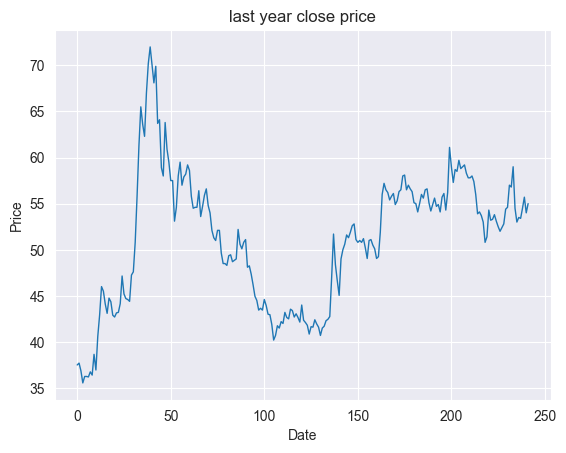

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
# plt.style.use("seaborn-darkgrid")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title('last year close price')
# plt.plot(test_10day['High']-test_10day['clo'],linewidth=1)
plt.plot(test_day['clo'],linewidth=1)

plt.show()

In [4]:
from sklearn.preprocessing import MinMaxScaler
import numpy as  np

MOVING_WIN_SIZE=35

scaler=MinMaxScaler(feature_range=(0,1))
scaler_prices=scaler.fit_transform(test_day.values)

all_x,all_y=[],[]
for i in range(len(scaler_prices)-MOVING_WIN_SIZE):
    x=scaler_prices[i:i+MOVING_WIN_SIZE]
    y=scaler_prices[i+MOVING_WIN_SIZE]
    all_x.append(x)
    all_y.append(y)

all_x,all_y=np.array(all_x),np.array(all_y)

In [5]:
DS_SPLIT=0.8

train_ds_size=round(all_x.shape[0]*DS_SPLIT)
train_x,train_y=all_x[:train_ds_size],all_y[:train_ds_size]
test_x,test_y=all_x[train_ds_size:],all_y[train_ds_size:]

In [6]:
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.models import Sequential

model =Sequential()
model.add(LSTM(units=128,return_sequences=True,input_shape=(train_x.shape[1],1)))
model.add(LSTM(units=50,return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.summary()

c:\Users\payten\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 35, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        35,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,661 (404.93 KB)

 Trainable params: 103,661 (404.93 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(optimizer="adam",loss="mean_squared_error")

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=30, min_lr=0.000001, verbose=1)
callback=EarlyStopping( monitor="val_loss",patience=200,restore_best_weights=True)
model.fit(train_x,train_y,
          validation_split=0.2,
          callbacks=[callback,reduce_lr],
          epochs=1000
          )

Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0987 - val_loss: 0.0186 - learning_rate: 0.0010
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0318 - val_loss: 0.0234 - learning_rate: 0.0010
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0217 - val_loss: 0.0163 - learning_rate: 0.0010
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0184 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0157 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0129 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0109 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 8/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0106 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 9/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0108 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 10/1000
5/5 ━

In [9]:
preds=scaler.inverse_transform(model.predict(test_x))
preds

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


array([[57.43578 ],
       [58.005085],
       [58.498188],
       [58.835625],
       [59.20202 ],
       [59.39407 ],
       [59.488117],
       [59.53222 ],
       [59.40661 ],
       [59.13078 ],
       [58.803177],
       [58.51301 ],
       [58.19579 ],
       [57.713936],
       [56.92074 ],
       [56.09504 ],
       [55.303165],
       [54.546204],
       [53.622707],
       [52.821636],
       [52.582172],
       [52.551533],
       [52.679882],
       [52.960445],
       [53.20567 ],
       [53.327633],
       [53.301266],
       [53.250324],
       [53.246212],
       [53.48694 ],
       [53.86462 ],
       [54.603935],
       [55.424137],
       [56.49171 ],
       [56.923706],
       [56.739872],
       [56.290535],
       [55.722015],
       [55.305153],
       [55.186207],
       [55.019073]], dtype=float32)

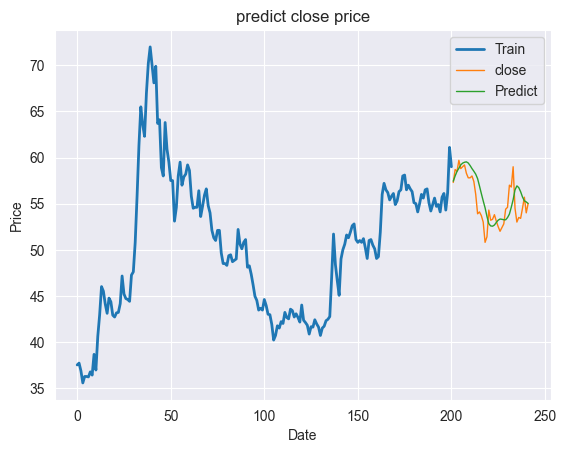

In [10]:
train_data=test_day[:train_ds_size+MOVING_WIN_SIZE]
test_data=test_day[train_ds_size+MOVING_WIN_SIZE:]
test_data=test_data.assign(Predict=preds)

plt.xlabel("Date")
plt.ylabel("Price")
plt.title('predict close price')
plt.plot(train_data['clo'],linewidth=2)
plt.plot(test_data['clo'],linewidth=1)
plt.plot(test_data['Predict'],linewidth=1)

plt.legend(["Train","close","Predict"])
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error

test_data=test_data.assign(Shifted=test_data['clo'].shift(1))
test_data.iat[0,-1]=train_data.iat[-1,-1]

predict_mse=mean_squared_error(test_data['clo'],test_data['Predict'],squared=False)
predict_cvrmse=predict_mse / test_data['clo'].mean()*100

shifted_rmse=mean_squared_error(test_data['clo'],test_data['Shifted'],squared=False)
shifted_cvrmse=shifted_rmse / test_data['clo'].mean()*100


print(f"predict_mse\t=  {predict_cvrmse} % \nshift_mse\t=  {shifted_cvrmse} %")

predict_mse	=  3.4105510480829033 % 
shift_mse	=  2.4433544924126283 %


c:\Users\payten\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\payten\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [12]:
model.save('./tsmc_v1.h5')